# Plot Coincidence Trigger

## Import Libraries

In [15]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from numpy import sort

## Configurations

In [35]:
config = {}

## before 2023-04-01
config['seeds'] = {"rotation":"PY.BSPF..HJ*", "translation":"II.PFO.10.BH*"}
## after 2023-04-01
# config['seeds'] = ["PY.BSPF..HJ*", "PY.PFOIX..HH*"]


# config['output_path'] = "/home/andbro/kilauea-data/BSPF/trigger/tmp/"
config['output_path'] = "/import/kilauea-data/BSPF/trigger/"


config['client'] = Client("IRIS")

In [37]:
!ls /import/kilauea-data/BSPF/trigger/tmp

trigger_000.pkl
trigger_001.pkl
trigger_002.pkl
trigger_003.pkl
trigger_004.pkl
trigger_005.pkl
trigger_006.pkl
trigger_007.pkl
trigger_008.pkl
trigger_009.pkl
trigger_010.pkl
trigger_011.pkl
trigger_012.pkl
trigger_013.pkl
trigger_014.pkl
trigger_015.pkl
trigger_016.pkl
trigger_017.pkl
trigger_018.pkl
trigger_019.pkl
trigger_020.pkl
trigger_021.pkl
trigger_022.pkl
trigger_023.pkl
trigger_024.pkl
trigger_2022-10-05T00:00:00.000000Z_000.pkl
trigger_2022-10-05T00:00:00.000000Z_001.pkl
trigger_2022-10-05T00:00:00.000000Z_002.pkl
trigger_2022-10-05T00:00:00.000000Z_003.pkl
trigger_2022-10-05T00:00:00.000000Z_004.pkl
trigger_2022-10-05T00:00:00.000000Z_005.pkl
trigger_2022-10-05T00:00:00.000000Z_006.pkl
trigger_2022-10-05T00:00:00.000000Z_007.pkl
trigger_2022-10-05T00:00:00.000000Z_008.pkl
trigger_2022-10-05T00:00:00.000000Z_009.pkl
trigger_2022-10-05T00:00:00.000000Z_010.pkl
trigger_2022-10-05T00:00:00.000000Z_011.pkl
trigger_2022-10-05T00:00:00.000000Z_012.pkl
trigger_2022-10-05T00:00:00.

## Load Data

In [18]:
def __request_data(seed, client, tbeg, tend):

#     print(seed)
    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print(f" -> Failed to load inventory for {seed}!")
        return

    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print(f" -> Failed to load waveforms for {seed}!")
        return
    
    return waveform, inventory

In [19]:
# st_xpfo, inv_xpfo = __request_data(config['seeds']['translation'], config['client'], config['tbeg'], config['tend'])

In [20]:
# st_bspf, inv_bspf = __request_data(config['seeds']['rotation'], config['client'], config['tbeg'], config['tend'])

## Load Triggered Events

In [53]:
def __read_pickle(config, filename):
    
    import pickle

    with open(config['output_path']+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [55]:
trigger_events = __read_pickle(config, "trigger_all.pkl")

In [68]:
times, cosum = [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    print(trig)
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    
rel_times = [(t-ref_time)/86400 for t in times]

{'time': UTCDateTime(2022, 10, 23, 9, 24, 59, 994538), 'stations': ['PFO', 'PFO', 'PFO', 'BSPF', 'BSPF', 'BSPF'], 'trace_ids': ['II.PFO.10.BH1', 'II.PFO.10.BHZ', 'II.PFO.10.BH2', 'PY.BSPF..HJ3', 'PY.BSPF..HJ1', 'PY.BSPF..HJ2'], 'coincidence_sum': 6.0, 'similarity': {}, 'duration': 44.299999952316284}
{'time': UTCDateTime(2022, 10, 25, 3, 55, 36, 344538), 'stations': ['PFO', 'PFO', 'PFO', 'BSPF'], 'trace_ids': ['II.PFO.10.BH1', 'II.PFO.10.BHZ', 'II.PFO.10.BH2', 'PY.BSPF..HJ2'], 'coincidence_sum': 4.0, 'similarity': {}, 'duration': 45.424999952316284}
{'time': UTCDateTime(2022, 10, 25, 3, 55, 40, 19538), 'stations': ['PFO', 'PFO', 'PFO', 'BSPF', 'BSPF'], 'trace_ids': ['II.PFO.10.BH1', 'II.PFO.10.BHZ', 'II.PFO.10.BH2', 'PY.BSPF..HJ2', 'PY.BSPF..HJ1'], 'coincidence_sum': 5.0, 'similarity': {}, 'duration': 41.75000023841858}
{'time': UTCDateTime(2022, 10, 26, 8, 14, 20, 294538), 'stations': ['PFO', 'PFO', 'PFO', 'BSPF', 'BSPF', 'BSPF'], 'trace_ids': ['II.PFO.10.BHZ', 'II.PFO.10.BH2', 'II.PF

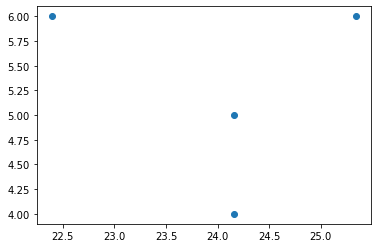

In [69]:
plt.scatter(rel_times, cosum)

## Process Data

In [ ]:
st_xpfo_proc = st_xpfo.copy()
st_xpfo_proc.remove_response(inventory=inv_xpfo)

st_bspf_proc = st_bspf.copy()
st_bspf_proc.remove_sensitivity(inventory=inv_bspf)
st_bspf_proc.resample(40.0)

In [ ]:
st = obs.Stream()

st += st_bspf_proc.copy()
st += st_xpfo_proc.copy()

st.detrend("linear")
st.taper(0.01)
st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=4, zerophase=True)  # optional prefiltering

In [ ]:
st.plot(equal_scale=False);